# Import package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path
import random
import os
import glob
import time
from datetime import datetime
import torch
import gym
from utility import Config_PPO
from agent.ppoagent import PPO
import time
################################## set device ##################################
print("============================================================================================")
# set device to cpu or cuda
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    device = torch.device('cpu')
    print("Device set to : cpu")
print("============================================================================================")


c:\Users\lynch\anaconda3\envs\DQN_win\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device set to : NVIDIA GeForce RTX 3070 Laptop GPU


# Create the storage folder and generate log file 
## Folder route
* The folder is saved under the route describes in the cell, (mainly 'document/model/``file_name``')
* The ``file_name`` is the name of storag folder for current training.



## Set reward function configuration car racing environment
1. In the car racing environment, the [car_racing.py](gym/envs/box2d/car_racing.py) contains the reward function configuration where user can play around for designing the risk awareness that the agent targeted to learn.
   * Reward function name: `default_reward_callback`
   * `OBSTACLE_VALUE = -600` -- default
2. Can modify the configuration of parameters before training, the log files are collected under the same directory.
   * The configuration file defines the training episodes, frequency of saving learned model in `*.pth` files for both actor and critic networks.

In [2]:
# create folder
file_name = 'PPO' # Folder name
p_model = (Path()/ 'document'/'model'/file_name) # storage under model directory
p_model.mkdir(parents=True, exist_ok=True) # create if no directory existed


# Track
# load_tracks_from=TRACK -- Load a specific map from a pkl file
TRACK = 'track'

# ENV
# Gym make the environment
frame = int(1) # state is frame - 1
env = gym.make('CarRacing-v0', num_obstacles=100, show_info_panel=1,
               num_tracks=1, num_lanes=1, discretize_actions='soft', 
               allow_outside=False, grayscale=1, frames_per_state=frame,load_tracks_from = TRACK)

state_dim = env.observation_space.shape
action_dim = env.action_space.n

# Parameters
""" configuration of parameter setup, and setup training configuration. """
Total_train = 3000          # Total training traing length 
Model_Save_frequency = 2    # the frequency of saving model under directory
Time_stamp = 500            # Exploring time stamps
cfg = Config_PPO(max_training_timesteps=int(Total_train),max_ep_len=Time_stamp,K_epochs=30, save_model_freq=Model_Save_frequency,eps_clip=0.2,gamma=0.95)
setattr(cfg, 'state_dim', state_dim)
setattr(cfg, 'action_dim', action_dim)

print('Max training time steps: {}\t \n State dimension: {}\t \n Action size: {}\t'.format(cfg.max_training_timesteps,cfg.state_dim,cfg.action_dim))
print("K-epocs:{}\n max timesteps in one episode: {} \n Expected episode: {}\n".format(cfg.K_epochs,cfg.max_ep_len,(cfg.max_training_timesteps // cfg.max_ep_len)*2))

agent = PPO(cfg)


if p_model.is_dir():
    nb_name = 'log_par.txt'
    with open(p_model.joinpath(nb_name), "w") as f:
        f.write('-----------------------Var Config-----------------------\n')
        for key, value in vars(cfg).items(): 
            f.write('%s:%s\n' % (key, value))
        f.write('-----------------------Var Env-----------------------\n')
        for key, value in vars(env).items():
            f.write('%s:%s\n' % (key, value))
        f.write('-----------------------Var File-----------------------\n')
        f.write('Directroy: %s,\n'% p_model)
        f.write('SOFT_NEG_REWARD = 0.1, \nOut side: -1, \nreward += ((((left | right) & not_visited).sum()+0.4)/ factor),\n max_time_out = 10.0,\ncheck_outside == False\n')
        print('Log File was created.')
        f.close()
else:
    print("Directory doesn\'t exist.")

Max training time steps: 3000	 
 State dimension: (96, 96)	 
 Action size: 5	
K-epocs:30
 max timesteps in one episode: 500 
 Expected episode: 12

Log File was created.


# Training function for PPO

In [3]:
from collections import deque
from utility import score_save

def PPO_train():
        print_running_reward = 0
        print_running_episodes = 0
        time_step = 0
        i_episode = 0
        scores_deque = deque(maxlen=100)
        scores = []
        avg_scores = []
        time_step = 0
        avg_print_score = []
        while time_step <= cfg.max_training_timesteps: # Max training time steps
        
                state = env.reset()
                current_ep_reward = 0
                score = 0        
        
                for t in range(1,cfg.max_ep_len+1):        
                        # sum_eval_reward =0
                        action = agent.select_action(state)
                        next_state, reward, done, _ = env.step(action)
                        agent.buffer.rewards.append(reward)
                        agent.buffer.is_terminals.append(done)                        
                        time_step += 1        
                        state = next_state
                        current_ep_reward += reward
                        score += reward

                        if time_step % cfg.update_timestep == 0:                       
                                agent.update()
                                print('\n ---------------- \n')
                        if time_step % cfg.print_freq == 0:
                                print_avg_reward = print_running_reward / (print_running_episodes+0.000000000001)
                                print_avg_reward = round(print_avg_reward, 2)
                                avg_print_score.append(print_avg_reward)
                                print("\nIsEpisode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))
                                print_running_reward = 0
                                print_running_episodes = 0
                        if done:
                                break
                # save model                      
                if i_episode % cfg.save_model_freq == 0:
                        model_name = f"PPO_adreward_{i_episode}.pth"
                        torch.save(agent.policy_old.state_dict(), (p_model /model_name))
                        file_name = f"PPO4_reshape_{i_episode}"
                        score_save(scores, averagescore=avg_scores, file_name=file_name, path=p_model, print_=False)
                scores_deque.append(score)
                scores.append(score)
                avg_scores.append(np.mean(scores_deque))
                print_running_reward += current_ep_reward
                print_running_episodes += 1
                i_episode += 1
        return i_episode, scores, avg_scores, avg_print_score, agent

## Start training

The following cell start training for the agent.

* Total training time are logged as `Run_log_training.txt` and will storage under the same directory.
* The learned models are storaged as the frequency of storaging episodes as setted up above. (default is `every 2 episode save model once.`)
* Plot for average scores and all scores are illustrated.
  * The score plot shows the score of the end result of single episode.
  * The average plot shows the averaging of last 100 time stamps' scoring. (in one episode)
    > Since the agent can result in a lower score, for instance, by hitting on the obstacle after exploring for a while on the track. Collision does not represent the total actions what the agent already done.

* The csv storages the score and average scores are under the same directory.

In [4]:
start = time.time()
i_episode, scores, avg_scores, avg_print_score, agent = PPO_train()
final_model = f"PPO_adreward_{i_episode}.pth"                        # save the final iteration of model
torch.save(agent.policy_old.state_dict(), (p_model /final_model))
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

if p_model.is_dir():
    nb_name = 'Run_log_training.txt'
    with open(p_model.joinpath(nb_name), "w") as f:
        f.write("Total training time: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
        f.write('Toal epoch:%s\n'%i_episode)
        f.write('Csv file name:%s\n'%file_name)
        f.close()


c:\Users\lynch\anaconda3\envs\DQN_win\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))



IsEpisode : 1 		 Timestep : 500 		 Average Reward : -583.55

IsEpisode : 3 		 Timestep : 1000 		 Average Reward : -247.42

IsEpisode : 4 		 Timestep : 1500 		 Average Reward : 84.0

 ---------------- 


IsEpisode : 5 		 Timestep : 2000 		 Average Reward : -25.05

IsEpisode : 7 		 Timestep : 2500 		 Average Reward : -249.12

IsEpisode : 8 		 Timestep : 3000 		 Average Reward : 83.0
Total training time: 00:00:41.40


# Plot training result

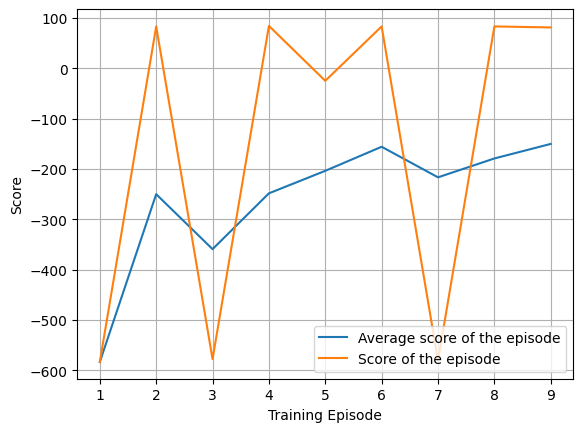

In [5]:
image_name = f'PPO_av{i_episode-1}.png'
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Average score of the episode")
plt.plot(np.arange(1, len(scores)+1), scores, label="Score of the episode")
plt.legend()
plt.ylabel('Score')
plt.xlabel(f'Training Episode')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
# plt.savefig((p_model/image_name))
plt.show()
